# Quantitative Risk Management

Click <a href="https://colab.research.google.com/github/Lolillosky/QuantRiskManagement/blob/main/NOTEBOOKS/15_Credit_Exposure_Equity.ipynb">
    <img src="https://upload.wikimedia.org/wikipedia/commons/d/d0/Google_Colaboratory_SVG_Logo.svg" width="30" alt="Google Colab">
</a> to open this notebook in Google Colab.





In this exercise, you are going to calculate exposures of equity products.

## Import main libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Import libaries from the repository:

In [3]:
import sys
sys.path.append('../CODE')  # Adjust the path as necessary


from IPython.display import clear_output

'''
!rm -r {'QuantRiskManagement'}

!git clone https://github.com/Lolillosky/QuantRiskManagement.git

import sys
sys.modules.pop
sys.path.insert(0,'QuantRiskManagement/CODE')
'''
clear_output()


In [4]:
import Option_formulas

## Credit exposure of a standalone forward contract

Data:

* Spot: 10
* Strike: 8
* Risk free rate: 1%
* Dividend yield: 0%
* Volatility: 20%
* Maturity: 5 years.





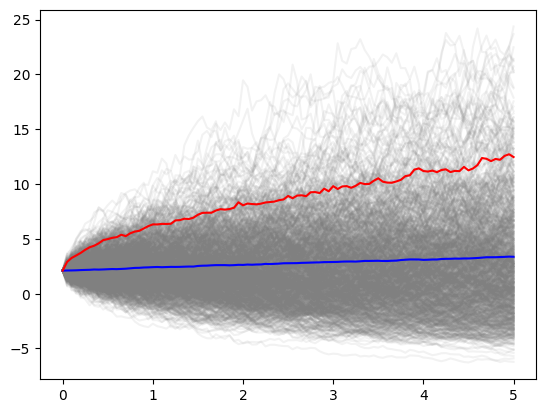

In [5]:
# Your code goes here
S_0 = 10
Strike = 8
rfr = 0.01
TTM = 5
vol = 0.2

num_sims = 1000
num_time_steps = 100

# Generate the stock price paths

delta_t = TTM/num_time_steps

time_grid = np.linspace(0, TTM, num_time_steps+1)
S_t = np.zeros((num_sims, num_time_steps+1))

S_t[:,0] = S_0

S_t[:,1:] = np.exp((rfr - 0.5*vol**2)*delta_t + vol*np.sqrt(delta_t)*np.random.randn(num_sims, num_time_steps))

S_t = S_t.cumprod(axis=1)

# Calculate the payoff of the forward contract

f_t = np.array([Option_formulas.forward_price(s, Strike, rfr, 0.0, TTM - t) for (s,t) in zip(S_t.T, time_grid)]).T

plt.plot(time_grid, f_t.T, 'grey', alpha = 0.1);

plt.plot(time_grid, np.maximum(f_t,0).mean(axis=0), 'blue');

plt.plot(time_grid, np.percentile(np.maximum(f_t,0),95, axis = 0), 'red');



In [6]:
f_t.shape

(1000, 101)

## Credit exposure of a netting set

* Spot A: 10
* Spot B: 10
* Risk free rate: 1%
* Dividend yield: 0%
* Volatility A: 20%
* Volatility B: 10%
* Correlation: 60%

* Forward 1:

   * Underlying: A

   * Strike: 10

   * Maturity: 5y

   * Position: Long

   * Notional: 1

* Forward 2:

   * Underlying: B

   * Strike: 10

   * Maturity: 10y

   * Position: Short

   * Notional: 1

* Option:

   * Underlying: B

   * Strike: 12

   * Type: Call

   * Maturity: 8y

   * Position: Short

   * Notional: 1


In [16]:
# Your code goes here

Spot = [10,10,8]
Vols = [0.2, 0.1, 0.05]
rho_1_2 = 0.8
rho_1_3 = 0.6
rho_2_3 = 0.4
TTM = 10
correl = np.array([[1, rho_1_2, rho_1_3], [rho_1_2, 1, rho_2_3], [rho_1_3, rho_2_3, 1]])
chol = np.linalg.cholesky(correl)

num_sims = 1000
num_time_steps = 100

delta_t = TTM/num_time_steps

# Generate the stock price paths
S_t = np.zeros((num_sims, num_time_steps+1, 3))

S_t[:,0,:] = Spot

Brownian = np.random.randn(num_sims, num_time_steps, 3)*np.sqrt(delta_t)

Brownian_correl = Brownian @ chol.T

S_t[:,1:,:] = np.exp((rfr - 0.5*np.array(Vols)**2)*delta_t + np.array(Vols)*Brownian_correl)

S_t = S_t.cumprod(axis=1)





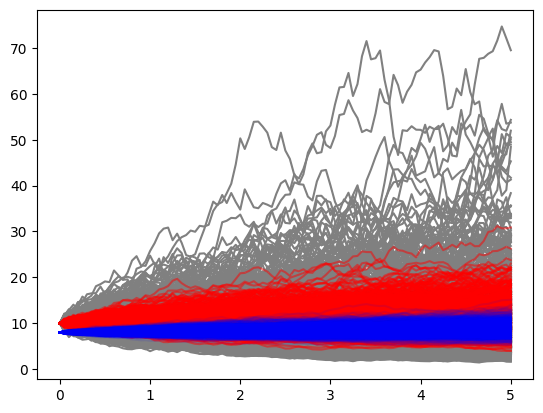

In [18]:
plt.plot(time_grid, S_t[:,:,0].T, 'grey', alpha = 1);
plt.plot(time_grid, S_t[:,:,1].T, 'red', alpha = 0.5);
plt.plot(time_grid, S_t[:,:,2].T, 'blue', alpha = 0.1);



In [60]:
Brownian_correl.T.shape

(3, 100, 100000)

In [51]:
print(np.corrcoef(Brownian_correl[:,0].T))

[[1.         0.79987872 0.60185944]
 [0.79987872 1.         0.39846559]
 [0.60185944 0.39846559 1.        ]]


In [35]:
Brownian_correl[0,:].shape

(100, 3)